Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Alex Arzamasov" 
COLLABORATORS = "Mary Tenuta, Samantha Scott"

In [ ]:
%%bash
pwd

# Homework 8
Curated by Sabah Ul-Hasan 

In this assignment, you will <br>
B8.aa Affirm your understanding of RNA-Seq Data Pre-processing <br>
B8.ab Practice RNA-Seq Data Pre-processing into variant calling <br>
B8.ba Practice read counting (feature and htseq-out) <br>
B8.bb Utilize count matrix for DESeq2, and application <br>

Note that there is a section at the end (B8.bb) to point out any enhancements you personally would make to this assignment if you were to lead the course

Complete this homework by Thursday at 8 AM PST. <br>
Save your homework as you go, so the efforts don't get lost. <br>
Note there are 12 points total, but 10 points possible.

## B8.aa: Understanding of RNA-Seq Pre-Processing [35 min] Groups of 3

### Question 1 (2 points)

1. Though in breakout groups, first spend 5 minutes on your own identifying the aspects of weeks 6-7 that have been unclear in reference to RNA-Seq analysis. What are the knowledge gaps you encountered in the workflow, vs what do you feel comfortable about? Write your notes in the space below.

2. Spend the next 30 minutes discussing these as a group. Take turns (5 min each) to briefly discuss an issue you encountered (1 of the 5 min) and then have another walk through their process (4 of the 5 min) of overcoming that experienced issue. Include the solutions below as code where appropriate. 

1. Gaps of knowledge:
   - Downloading FASTQ files from SRA 
   - Counting features: using `Feature counts` (Galaxy) vs `htseq`. Which tool is better?
   - How thorough should be QC after mapping reads
   Comfortable:
   - QC with FastQC
   - Mapping reads
2. We discussed some troubles in HW6, specifically questions 4 and 6
    - In question 4, we discussed how to calculate the number of aligned reads (e.g., multiply the 98.31% overall alignment rate in `hisat2` output by the total number of reads)
    - In question 6, we troubleshooted piping from `hisat2` output to `samtools`

## B8.ab: Raw Data to Variant Calling Format [20-30 min] Individual

#### Question 2 (3 points) <br>
Practice makes perfect. <br>
Complete the following tutorial. Use the data folder of this homework to load and utilize the files shared in the tutorial through 'Explore the VCF format', and write a complete script that walks through the analysis step-by-step (replicated VCF in data folder for full points). <br>
https://datacarpentry.org/wrangling-genomics/04-variant_calling/index.html

In [ ]:
%%bash
#make all directories
mkdir -p data/ref_genome
mkdir -p results/sam results/bam results/bcf results/vcf

In [ ]:
%%bash
#download and unzip the reference genome
curl -L -o data/ref_genome/ecoli_rel606.fasta.gz ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/017/985/GCA_000017985.1_ASM1798v1/GCA_000017985.1_ASM1798v1_genomic.fna.gz
gunzip data/ref_genome/ecoli_rel606.fasta.gz

In [ ]:
%%bash
#download reads
curl -L -o sub.tar.gz https://ndownloader.figshare.com/files/14418248
tar xvf sub.tar.gz
mv sub/ ./data/trimmed_fastq_small

In [ ]:
%%bash
#index the reference genome
bwa index data/ref_genome/ecoli_rel606.fasta

In [ ]:
%%bash
#align reads the reference genome
bwa mem data/ref_genome/ecoli_rel606.fasta data/trimmed_fastq_small/SRR2584866_1.trim.sub.fastq data/trimmed_fastq_small/SRR2584866_2.trim.sub.fastq > results/sam/SRR2584866.aligned.sam

In [ ]:
%%bash
#convert sam to bam; sort the bam file
samtools view -S -b results/sam/SRR2584866.aligned.sam > results/bam/SRR2584866.aligned.bam
samtools sort -o results/bam/SRR2584866.aligned.sorted.bam results/bam/SRR2584866.aligned.bam 

In [ ]:
%%bash
#calculate the read coverage of positions in the genome
bcftools mpileup -O b -o results/bcf/SRR2584866_raw.bcf \
-f data/ref_genome/ecoli_rel606.fasta results/bam/SRR2584866.aligned.sorted.bam 
#detect the single nucleotide polymorphisms (SNPs)
bcftools call --ploidy 1 -m -v -o results/bcf/SRR2584866_variants.vcf results/bcf/SRR2584866_raw.bcf 
#filter and report the SNP variants in variant calling format (VCF)
vcfutils.pl varFilter results/bcf/SRR2584866_variants.vcf  > results/vcf/SRR2584866_final_variants.vcf

#### Question 3 (1 point) <br>
Reading-up (recommended to complete this before submitting HW7 this Thursday) <br>

There's more to developing a count matrix than meets the eye. Here are some details that may fill knowledge gaps encountered from the Galaxy tutorial. In the space below (2 paragraphs, 4-6 sentences each), describe your updated understanding of read counting.<br>
https://hbctraining.github.io/Intro-to-rnaseq-hpc-O2/lessons/05_counting_reads.html

1. There two commonly used tools for counting how many reads have mapped to each gene: `featureCounts` and `htseq-count`
2. Input for counting = multiple BAM files + 1 GTF file. The GFT file contains genomic coordinates of whichever features we are interested in counting expression (exons, genes, or transcripts)
3. Output of counting = a **count matrix**, with genes as rows and samples are columns. These are the “raw” counts and can be used for assessing differential gene expression.
4. `featureCounts`  counts reads that map to a single location (uniquely mapping). FeatureCounts can also take into account whether your data are stranded or not.
5. The `featureCounts` output is a count matrix and a summary file that tabulates how many the reads were “assigned” or counted and the reason they remained “unassigned”
6. Paired reads: for most counting tools, only properly paired reads are considered by default, and each read pair is counted only once as a single “fragment”. **NB:  the input bam files need to be sorted by read name for proper working of `featureCounts`**

## B8.ba: Practice read counting in prep for DESeq2 [20-30 min] Individual

#### Question 4 (3 points) <br>
Walk through the following tutorial (2.2 section only) on how to convert sam files to a count matrix. For files, use your output from HW6. Confirm they are the proper format before starting. Know that this means you will need to transfer files from that data folder to this one (HW8). <br>
https://youngleebbs.gitbook.io/bioinfo-training/part-ii/2.-construction-of-expression-matrix <br><br>

Additionally helpful reading: <br>
https://htseq.readthedocs.io/en/release_0.10.0/count.html

In the space below, write a bash script from starting with the sam files to viewing the count matrix. In you script, comment on the different filter steps of the data. What is happening to the original data set with each command? <br> 

In [ ]:
%%bash
cd ./data/q4
#align reads to the reference human genome (hg38) with a prebuilt index; outputs a sorted bam file
module load hisat2
module load samtools
hisat2 -x ./hg38_prebuilt_index/genome -1 SRR12742806_subsampled_R1.fastq.gz -2 SRR12742806_subsampled_R2.fastq.gz | samtools sort -o SRR12742806_subsampled.bam

In [ ]:
%%bash
cd ./data/q4
#count for raw counts using htseq
module load subread
htseq-count SRR12742806_subsampled.bam hg38.ncbiRefSeq.gtf > SRR12742806_subsampled.htseq.counts

In [ ]:
%%bash
cd ./data/q4
#count for raw counts using featureCounts
featureCounts -t exon -g gene_id -a hg38.ncbiRefSeq.gtf -o counts.txt SRR12742806_subsampled.bam

In [ ]:
%%bash
#comparison of outputs
cd ./data/q4
cat SRR12742806_subsampled.htseq.counts | head
cat counts.txt | cut -f 1,7 | sort | head -20

## B8.bb: DESeq2 Analysis [20-30 min] Individual

#### Question 5 (2 points) <br>
Note that you will need to create a new notebook for this section (R kernel). <br>
Label the notebook HW8-Q5. <br><br> First, read through the following piece. Be sure to explore more in-depth on the 'Formatting Count Data' section: http://dowell.colorado.edu/HackCon/pages/deseq2.html <br>

Next, walk through the following tutorial using your own count matrix.<br> 
Include the script for working with your matrix below <br>
https://lashlock.github.io/compbio/R_presentation.html

Ask a scientific question about your matrix and answer it using one of the two plot types (volcano or PCA). For an additional bonus point (3 points instead of 2), include another visual of your choosing that answers a different question about the data. 

In [1]:
library("DESeq2")
library(ggplot2)
setwd('/home_local/aarzamasov/HW8/data/q5')

#read the file with counts (normalized?)
countData <- read.csv('airway_scaledcounts.txt', header = TRUE, sep = ",")
head(countData)
#read the file with metadata
metaData <- read.csv('airway_metadata.txt', header = TRUE, sep = ",")
metaData

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max

,ensgene,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003,723,486,904,445,1170,1097,806,604
2,ENSG00000000005,0,0,0,0,0,0,0,0
3,ENSG00000000419,467,523,616,371,582,781,417,509
4,ENSG00000000457,347,258,364,237,318,447,330,324
5,ENSG00000000460,96,81,73,66,118,94,102,74
6,ENSG00000000938,0,0,1,0,2,0,0,0


id,dex,celltype,geo_id
<fct>,<fct>,<fct>,<fct>
SRR1039508,control,N61311,GSM1275862
SRR1039509,treated,N61311,GSM1275863
SRR1039512,control,N052611,GSM1275866
SRR1039513,treated,N052611,GSM1275867
SRR1039516,control,N080611,GSM1275870
SRR1039517,treated,N080611,GSM1275871
SRR1039520,control,N061011,GSM1275874
SRR1039521,treated,N061011,GSM1275875


In [3]:
#construct DESEQDataSet Object
dds <- DESeqDataSetFromMatrix(countData=countData, 
                              colData=metaData, 
                              design=~dex, tidy = TRUE)
#Design specifies how the counts from each gene depend on our variables in the metadata
#For this dataset the factor we care about is our treatment status (dex)
#tidy=TRUE argument, which tells DESeq2 to output the results table with rownames as a first #column called 'row'

dds

#run the DESeq function
dds.result <- DESeq(dds)

converting counts to integer mode



class: DESeqDataSet 
dim: 38694 8 
metadata(1): version
assays(1): counts
rownames(38694): ENSG00000000003 ENSG00000000005 ... ENSG00000283120
  ENSG00000283123
rowData names(0):
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(4): id dex celltype geo_id

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [4]:
#what happens duting DESeq function

#estimateSizeFactors
#This calculates the relative library depth of each sample (NORMALIZATION)

#estimateDispersions
#estimates the dispersion of counts for each gene 

#nbinomWaldTest
#calculates the significance of coefficients in a Negative Binomial GLM using the size and dispersion outputs

In [9]:
#look at results (DE table)
res <- results(dds.result)
head(results(dds.result, tidy=TRUE))

,row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003,747.1941954,-0.35070302,0.1682457,-2.0844697,0.03711747,0.1630348
2,ENSG00000000005,0.0000000,NA,NA,NA,NA,NA
3,ENSG00000000419,520.1341601,0.20610777,0.1010592,2.0394752,0.04140263,0.1760317
4,ENSG00000000457,322.6648439,0.02452695,0.1451451,0.1689823,0.86581056,0.9616942
5,ENSG00000000460,87.6826252,-0.14714205,0.2570073,-0.5725210,0.56696907,0.8158486
6,ENSG00000000938,0.3191666,-1.73228897,3.4936010,-0.4958463,0.62000288,NA


In [11]:
#look at results (normalized counts)
head(counts(dds.result, normalized = TRUE))

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,709.25491,539.66105,767.1263610,663.2037,997.273745,787.54511,877.9928,635.49583
ENSG00000000005,0.00000,0.00000,0.0000000,0.0000,0.000000,0.00000,0.0000,0.00000
ENSG00000000419,458.12177,580.74636,522.7321221,552.9182,496.079760,560.68617,454.2469,535.54202
ENSG00000000457,340.40311,286.48673,308.8871631,353.2119,271.053890,320.90489,359.4760,340.89512
ENSG00000000460,94.17493,89.94351,61.9471508,98.3628,100.579745,67.48335,111.1108,77.85876
ENSG00000000938,0.00000,0.00000,0.8485911,0.0000,1.704741,0.00000,0.0000,0.00000


In [12]:
# look at some statistically significant differentially expressed genes (lowest padj)
res <- res[order(res$padj),]
head(res)
#SPARCL1 = ENSG00000152583; upregulated in dex treated
#PER1 = ENSG00000179094; upregulated in dex treated
#ARHGEF2 = ENSG00000116584; downregulated in dex treated
#MAOA = ENSG00000189221; upregulated in dex treated
#DUSP1 = ENSG00000120129; upregulated in dex treated

log2 fold change (MLE): dex treated vs control 
Wald test p-value: dex treated vs control 
DataFrame with 6 rows and 6 columns
                        baseMean    log2FoldChange              lfcSE
                       <numeric>         <numeric>          <numeric>
ENSG00000152583 954.770931565544  4.36835864527065  0.237126791795801
ENSG00000179094 743.252688449073  2.86388865850472  0.175569314418958
ENSG00000116584 2277.91345410747 -1.03470077244439 0.0650984360861076
ENSG00000189221 2383.75370672631  3.34154402446202  0.212405785251498
ENSG00000120129 3440.70375496308   2.9652108028191  0.203695128555355
ENSG00000148175 13493.9203682606  1.42716828092124   0.10038904128295
                             stat               pvalue                 padj
                        <numeric>            <numeric>            <numeric>
ENSG00000152583  18.4220374770321 8.74489803946092e-76 1.32441480807636e-71
ENSG00000179094  16.3120114012103 8.10783556293256e-60 6.13965848003068e-56
ENSG00000

In [18]:
#install EnhancedVolcano
if (!requireNamespace('BiocManager', quietly = TRUE))
    install.packages('BiocManager')

BiocManager::install('EnhancedVolcano')

Bioconductor version 3.8 (BiocManager 1.30.10), R 3.5.1 (2018-07-02)

Installing package(s) 'EnhancedVolcano'

Warning message in system2(cmd0, args, env = env, stdout = outfile, stderr = outfile, :
“error in running command”
Warning message in install.packages(...):
“installation of package ‘EnhancedVolcano’ had non-zero exit status”
Installation path not writeable, unable to update packages: ade4, admisc,
  alakazam, ape, arm, assist, backports, BDgraph, bibtex, bit, bit64, brglm,
  broom, callr, car, chron, cli, clipr, clusterGeneration, coda, colourpicker,
  covr, cowplot, cubature, data.table, dbplyr, deldir, dendextend, devtools,
  digest, doMC, doParallel, DT, e1071, Ecdat, Ecfun, effects, ergm, expm, fda,
  fields, fit.models, flexmix, foreach, Formula, fpc, fs, future, gbm,
  generics, ggraph, globals, GMMAT, gmp, gplots, graphlayouts, haplo.stats,
  Hmisc, htmlTable, htmlwidgets, httr, igraph, inline, IRkernel, iterators,
  jomo, KernSmooth, knitr, labeling, lava, lavaan, lei

Warning message:
“Removed 13578 rows containing missing values (geom_point).”


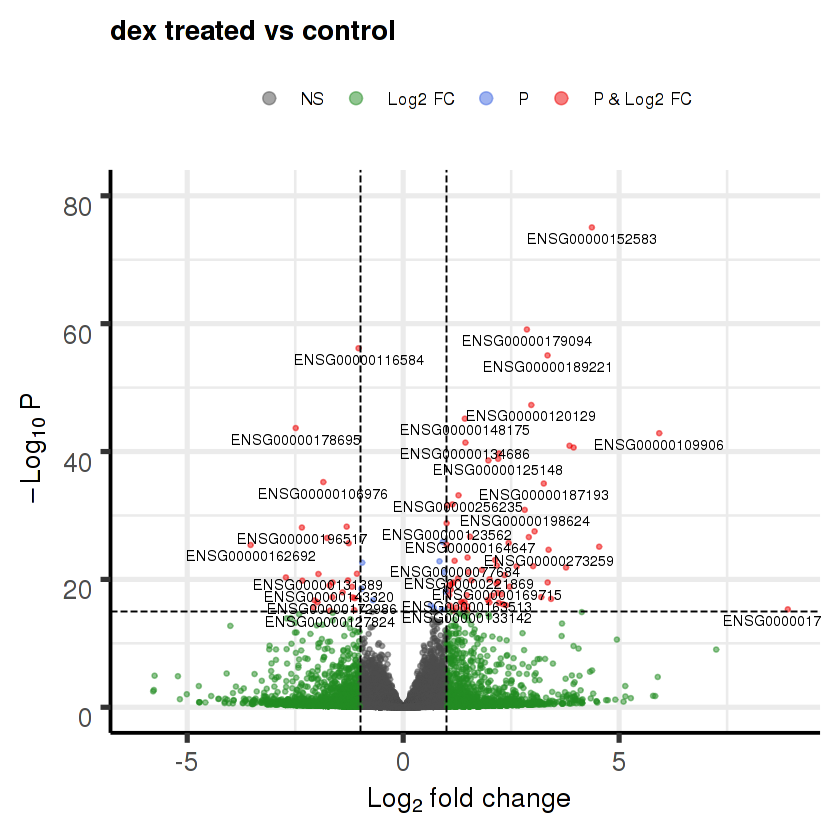

In [25]:
#create a volcano plot
library(EnhancedVolcano)
  EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'pvalue',
    title = 'dex treated vs control',
    pCutoff = 10e-16,
    FCcutoff = 1)

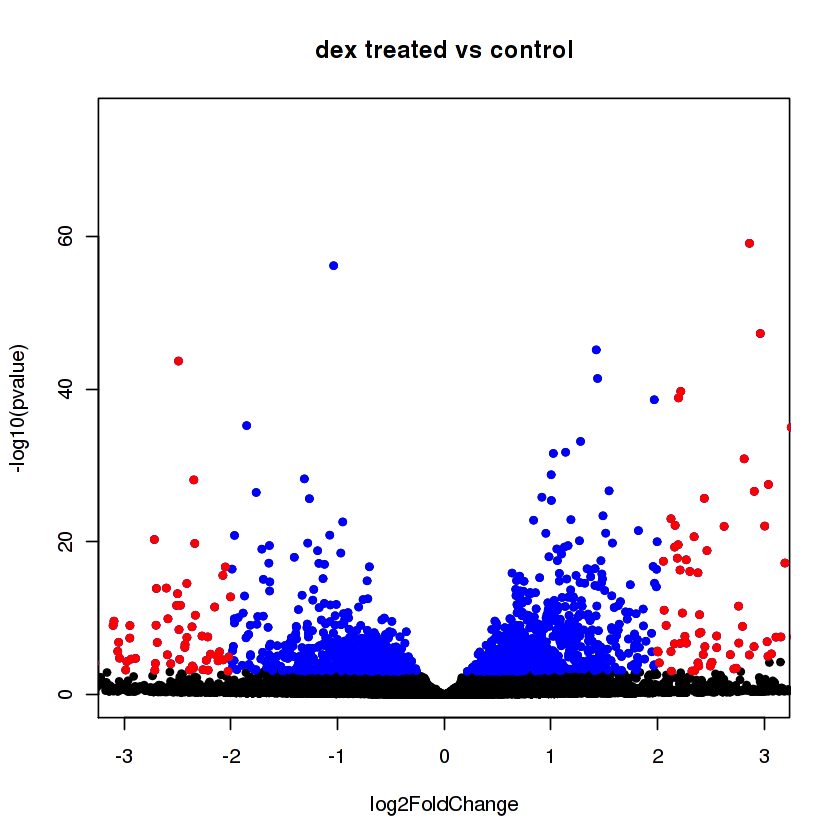

In [27]:
#reset par
par(mfrow=c(1,1))
# Make a basic volcano plot
with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main="dex treated vs control", xlim=c(-3,3)))

# Add colored points: blue if padj<0.01, red if log2FC>1 and padj<0.05)
with(subset(res, padj<.01 ), points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))
with(subset(res, padj<.01 & abs(log2FoldChange)>2), points(log2FoldChange, -log10(pvalue), pch=20, col="red"))

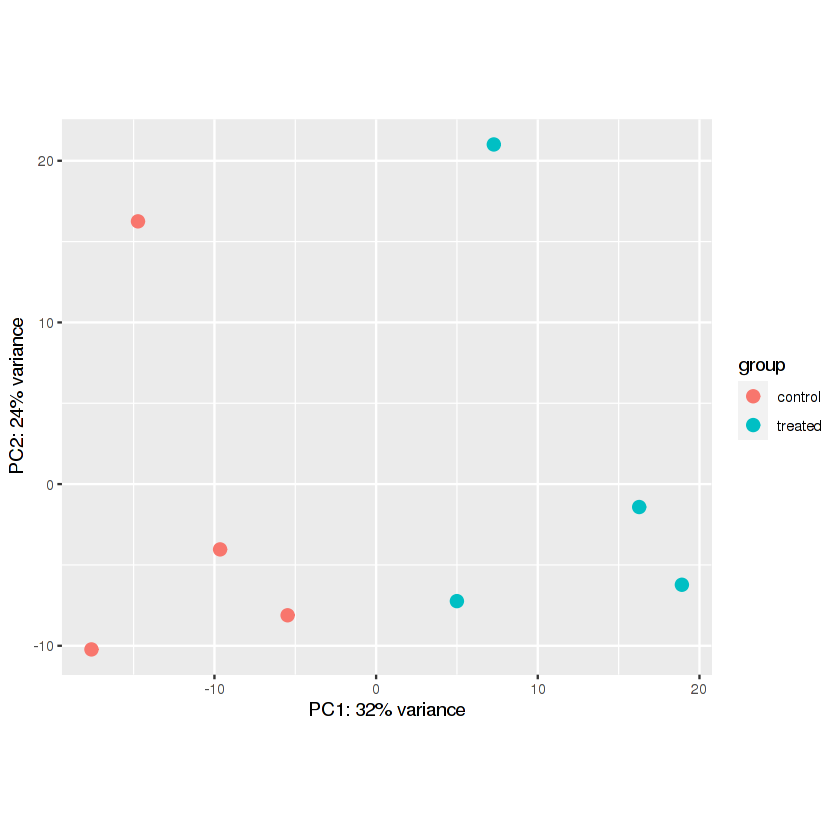

In [29]:
#create a PCA plot
vsdata <- vst(dds, blind=FALSE)
plotPCA(vsdata, intgroup="dex")

#### Question 6 (1 point) <br>
Reflections: On an integer scale of 1-5, 1 being very easy and 5 being the most difficult, where would you rank HW7 (both HW7.a and HW7.b), and why? Include some notes about what you gained from this past week that you didn't know before as well as notes of things you already knew. 

Improvements: Notice a [potentially intentional] mistake, or an area of this homework that could have been improved? Include your thoughts here. 

Tutorials tutorials tutorials!!
In your response, include comments on the advantages and disadvantages of tutorials in parallel with class material.

1. Reflections
    - 4/5. 
    - Tutorials for Q4 and the first tutorial in Q5 were not particularly useful. I think it better when the material is covered in the class in the form of a lecture than self-education via tutorials
    - Some questions were impposible to complete with data from HW6
    - Overall, because of the format homework takes too much time
2. Improvements
   - More info in class about how DESeq works (algoritm, normalization, how padj are calculated, output files)
   - Some info on psedoaligners (e.g., Kallisto)